# Проектирование валидации
### Описание этапа

На данном этапе вам необходимо:

* Сформировать обучающую выборку
* Спроектировать схему валидации с учетом специфики задачи
* Обосновать выбор способа валидации


In [100]:
import numpy as np
import pandas as pd
import matplotlib as plt
import seaborn as sns
from scipy.sparse import csr_matrix
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

In [ ]:
# Подгружаем данные
wb_data = pd.read_csv("/content/sample_data/wb_school_task_1.csv")
wb_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2274818 entries, 0 to 2274817
Data columns (total 3 columns):
 #   Column    Dtype  
---  ------    -----  
 0   user_id   int64  
 1   item_id   float64
 2   order_ts  object 
dtypes: float64(1), int64(1), object(1)
memory usage: 52.1+ MB


Мною были выбраны следующие реализации: в качестве baseline я взял MostPopular алгоритм, Двухэтапная архитектура (LightFM + градиентный бустинг)

## 1. Baseline

Так как в качестве baseline мною выбран MostPopular алгоритм, для него не требуется специальной предобработки данных, можно сгруппировать данные по месяцам, в качестве реализации брать топ 100 товаров на каждый отдельный месяц и рандомно выкидывать по 10 товаров, для повышения точности алгоритма. Для данного этапа добавим в таблицу столбец с наименованием месяца. В последующей реализации я напишу функцию, принимающую DataFrame, название месяца, возвращать она будет 10 случайно выбранных товаров из 100 самых популярных в указанном месяце. Поскольку на данном этапе не требуется реализовывать алгоритм, я считаю что такой выборки достаточно для дальнейшей работы.

In [ ]:
wb_data['order_ts'] = pd.to_datetime(wb_data['order_ts'])
baseline_data = wb_data.copy()
baseline_data['month_name'] = baseline_data['order_ts'].dt.month_name()

In [47]:
wb_data

user_id  item_id            order_ts
0         550614    264.0 2023-01-01 00:28:09
1         571051    580.0 2023-01-01 00:41:47
2         571051    180.0 2023-01-01 00:41:47
3          47164   5135.0 2023-01-01 00:53:35
4         219072   2668.0 2023-01-01 01:02:29
...          ...      ...                 ...
2274813   909507    721.0 2023-01-07 20:15:16
2274814    94347   2940.0 2023-01-07 20:17:23
2274815   802539   1620.0 2023-01-07 20:18:58
2274816   410546    203.0 2023-01-07 20:30:06
2274817       86      NaN                 NaT

[2274818 rows x 3 columns]

In [ ]:
baseline_data

user_id  item_id            order_ts month_name
0         550614    264.0 2023-01-01 00:28:09    January
1         571051    580.0 2023-01-01 00:41:47    January
2         571051    180.0 2023-01-01 00:41:47    January
3          47164   5135.0 2023-01-01 00:53:35    January
4         219072   2668.0 2023-01-01 01:02:29    January
...          ...      ...                 ...        ...
2274813   909507    721.0 2023-01-07 20:15:16    January
2274814    94347   2940.0 2023-01-07 20:17:23    January
2274815   802539   1620.0 2023-01-07 20:18:58    January
2274816   410546    203.0 2023-01-07 20:30:06    January
2274817       86      NaN                 NaT        NaN

[2274818 rows x 4 columns]

In [ ]:
baseline_data['order_ts'] = pd.to_datetime(wb_data['order_ts'])
max_date = baseline_data['order_ts'].max()
min_date = baseline_data['order_ts'].min()

print(f"min дата в wb_data: {min_date}")
print(f"max дата в wb_data: {max_date}")

min дата в wb_data: 2023-01-01 00:00:05
max дата в wb_data: 2023-02-21 06:26:44.549437


Для теста выделим последнюю неделю из датафрейма, опять же при реализации будет учитываться последняя неделя месяца, сейчас делаю для всего датафрейма

In [ ]:
train = baseline_data[(baseline_data['order_ts'] < max_date - pd.Timedelta(days=7))]
test = baseline_data[(baseline_data['order_ts'] >= max_date - pd.Timedelta(days=7))]

print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (2179443, 4)
test: (95374, 4)


# 2. Двухэтапная архитектура

Здесь используется LightFM + бустинг, поэтому придется сделать несколько разбиений, общая схема выглядит следующим образом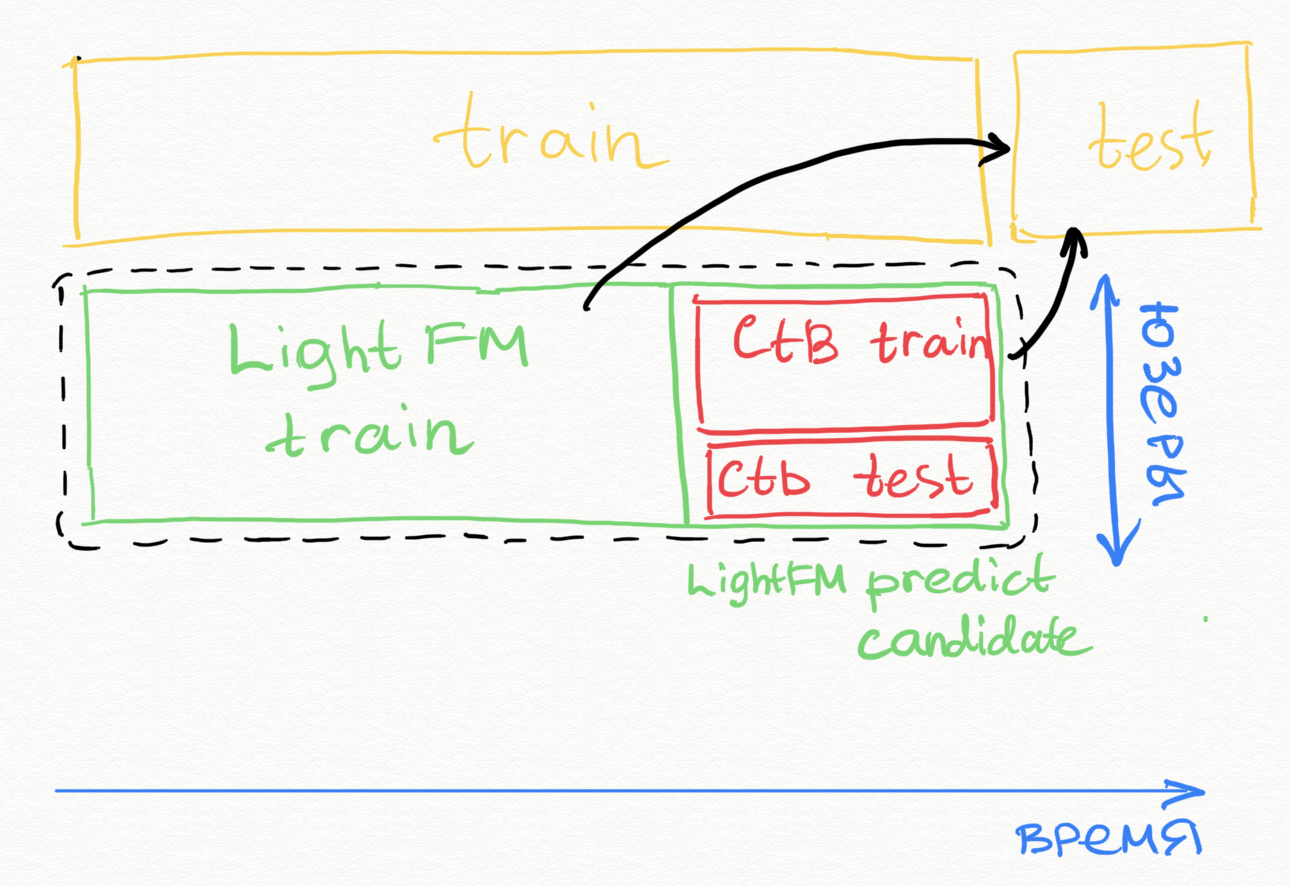

# Глобальный train - test

In [69]:
wb_data['action'] = 1
train = wb_data[(wb_data['order_ts'] < max_date - pd.Timedelta(days=7))]
test = wb_data[(wb_data['order_ts'] >= max_date - pd.Timedelta(days=7))]


print(f"train: {train.shape}")
print(f"test: {test.shape}")

train: (2179443, 4)
test: (95374, 4)


Разделим данные для LightFM еще на 2 части
train + pred for candidates
Разделим данные на lfm_train и lfm_pred как 60%-40% по квантилю даты покупки

На lfm_pred будем в дальнейшем обучать бустинг - модель 2 этапа

In [70]:
lfm_date_threshold = train['order_ts'].quantile(q=0.6, interpolation='nearest')
lfm_date_threshold

Timestamp('2023-01-12 04:53:00')

In [71]:
lfm_train = train[(train['order_ts'] < lfm_date_threshold)]
lfm_pred = train[(train['order_ts'] >= lfm_date_threshold)]

print(f"lfm_train: {lfm_train.shape}")
print(f"lfm_pred: {lfm_pred.shape}")

lfm_train: (1307665, 4)
lfm_pred: (871778, 4)


Будем предсказывать кандидатов только на теплых пользователях - у которых есть покупки в обучающей выборке

In [72]:
lfm_pred = lfm_pred[lfm_pred['user_id'].isin(lfm_train['user_id'].unique())]

In [73]:
lfm_train.head(3)

user_id  item_id            order_ts  action
0   550614    264.0 2023-01-01 00:28:09       1
1   571051    580.0 2023-01-01 00:41:47       1
2   571051    180.0 2023-01-01 00:41:47       1

In [57]:
pip install lightfm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.4/316.4 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lightfm: filename=lightfm-1.17-cp310-cp310-linux_x86_64.whl size=808332 sha256=cea046b46b6243e4ddd8f0462d729df8b0a7ff8de7386222fdadd7ec55f8622d
  Stored in directory: /root/.cache/pip/wheels/4f/9b/7e/0b256f2168511d8fa4dae4fae0200fdbd729eb424a912ad636
Successfully built lightfm


In [58]:
from lightfm.data import Dataset
from lightfm import LightFM

In [74]:
dataset = Dataset()
dataset.fit(lfm_train['user_id'].unique(), lfm_train['item_id'].unique())

In [75]:
interactions_matrix, weights_matrix = dataset.build_interactions(
    zip(*lfm_train[['user_id', 'item_id', 'action']].values.T)
)

weights_matrix_csr = weights_matrix.tocsr()

In [62]:
# user / item mappings
lightfm_mapping = dataset.mapping()
lightfm_mapping = {
    'users_mapping': lightfm_mapping[0],
    'items_mapping': lightfm_mapping[2],
}

lightfm_mapping['users_inv_mapping'] = {v: k for k, v in lightfm_mapping['users_mapping'].items()}
lightfm_mapping['items_inv_mapping'] = {v: k for k, v in lightfm_mapping['items_mapping'].items()}

print(f"users_mapping amount: {len(lightfm_mapping['users_mapping'])}")
print(f"items_mapping amount: {len(lightfm_mapping['items_mapping'])}")

users_mapping amount: 403936
items_mapping amount: 5440


In [63]:
lfm_model = LightFM(
    no_components=64,
    learning_rate=0.1,
    loss='warp',
    max_sampled=5,
    random_state=42
)

In [67]:
pip install tqdm

In [66]:
pip install dill

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.0 MB/s eta 0:00:00


In [76]:
from tqdm.auto import tqdm
from zipfile import ZipFile
import dill

In [90]:
#train model

num_epochs = 20

for _ in tqdm(range(num_epochs)):
    lfm_model.fit_partial(
        weights_matrix_csr
    )

  0%|          | 0/20 [00:00<?, ?it/s]

In [77]:
# save model
with open(f"lfm_model.dill", 'wb') as f:
    dill.dump(lfm_model, f)

Генерируем предсказания LightFM как кандидатов для второго этапа

In [86]:
# пустой датафрейм для предсказания
candidates = pd.DataFrame({
    'user_id': lfm_pred['user_id'].unique()
})

candidates.head(3)

user_id
0   305122
1    50412
2     2303

In [54]:
def generate_lightfm_recs_mapper(model, item_ids, known_items,
                                 user_features, item_features, N,
                                 user_mapping, item_inv_mapping,
                                 num_threads=1):
    def _recs_mapper(user):
        user_id = user_mapping[user]
        recs = model.predict(user_id, item_ids, user_features=user_features,
                             item_features=item_features, num_threads=num_threads)

        additional_N = len(known_items[user_id]) if user_id in known_items else 0
        total_N = N + additional_N
        top_cols = np.argpartition(recs, -np.arange(total_N))[-total_N:][::-1]

        final_recs = [item_inv_mapping[item] for item in top_cols]
        if additional_N > 0:
            filter_items = known_items[user_id]
            final_recs = [item for item in final_recs if item not in filter_items]
        return final_recs[:N]
    return _recs_mapper

In [93]:


# кол-во кандидатов
top_N = 30

# вспомогательные данные
all_cols = list(lightfm_mapping['items_mapping'].values())

mapper = generate_lightfm_recs_mapper(
    lfm_model,
    item_ids=all_cols,
    known_items=dict(),
    N=top_N,
    user_features=None,
    item_features=None,
    user_mapping=lightfm_mapping['users_mapping'],
    item_inv_mapping=lightfm_mapping['items_inv_mapping'],
    num_threads=20
)

In [94]:
# генерируем предказания
candidates['item_id'] = candidates['user_id'].map(mapper)
candidates = candidates.explode('item_id')
candidates['rank'] = candidates.groupby('user_id').cumcount() + 1

candidates.head()

user_id item_id  rank
0   305122  1457.0     1
0   305122   108.0     2
0   305122    82.0     3
0   305122  1321.0     4
0   305122  2884.0     5

In [96]:
candidates.shape

(6719040, 3)

Собираем train + target, 1 - пользователь покупал из списка кандидатов, 0 - не покупал

In [97]:
pos = candidates.merge(lfm_pred,
                        on=['user_id', 'item_id'],
                        how='inner')

pos['target'] = 1
print(pos.shape)
pos.head()

(138637, 6)


user_id item_id  rank                   order_ts  action  target
0   305122   357.0    14 2023-01-12 04:53:00.000000       1       1
1   305122   357.0    14 2023-01-28 09:51:10.099102       1       1
2   305122    76.0    17 2023-01-17 10:49:28.000000       1       1
3     2303   133.0    18 2023-01-12 05:03:52.000000       1       1
4     2303   170.0    22 2023-02-03 07:56:04.712982       1       1

In [98]:
neg = candidates.set_index(['user_id', 'item_id'])\
        .join(lfm_pred.set_index(['user_id', 'item_id']))


neg = neg.sample(frac=0.07)
neg['target'] = 0

neg.shape

(471745, 4)

In [106]:
neg.head()

rank                   order_ts  action  target
user_id item_id                                                 
953501  38.0       29                        NaT     NaN       0
932934  351.0      29                        NaT     NaN       0
284240  357.0      10                        NaT     NaN       0
702593  358.0      17                        NaT     NaN       0
615119  11.0        7 2023-01-26 08:52:19.251049     1.0       0

### Формируем трейн и тест: ctb_train, ctb_test
Делим по пользователям, а не по дате.
Мотивация:

Для негативных взаимодействий нет даты
Проверяем робастность бустинга относительно новых (холодных) пользователей

In [119]:
ctb_train_users, ctb_test_users = train_test_split(lfm_pred['user_id'].unique(),
                                                  random_state=1,
                                                  test_size=0.2)

Early stopping -  это форма регуляризации, которая используется для предотвращения переобучения при обучении с помощью итеративного метода, такого как градиентный спуск.

Такие методы обновляют обучающую модель с каждой итерацией, чтобы она лучше соответствовала обучающим данным. До определённого момента это улучшает производительность модели на данных за пределами обучающего набора. Однако после этого момента улучшение соответствия модели обучающим данным происходит за счёт увеличения ошибки обобщения.

Правила ранней остановки определяют, сколько итераций можно выполнить до того, как модель начнёт переобучать.

In [111]:
# выделяем 10% под механизм early stopping
ctb_train_users, ctb_eval_users = train_test_split(ctb_train_users,
                                                  random_state=1,
                                                  test_size=0.1)

In [ ]:
select_col = ['user_id', 'item_id', 'rank', 'target']

# Catboost train
ctb_train = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_train_users)],
        neg[neg['user_id'].isin(ctb_train_users)]
])[select_col]
)

# Catboost test
ctb_test = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_test_users)],
        neg[neg['user_id'].isin(ctb_test_users)]
])[select_col]
)

# for early stopping
ctb_eval = shuffle(
    pd.concat([
        pos[pos['user_id'].isin(ctb_eval_users)],
        neg[neg['user_id'].isin(ctb_eval_users)]
])[select_col]
)

Проверяем баланс классов

In [ ]:
ctb_train['target'].value_counts(normalize=True)

In [ ]:
ctb_test['target'].value_counts(normalize=True)